# Week 3 Lab: Prompting for Effective LLM Use

Focus: clear rules, roles (system vs. user), separating data from instructions, formatting outputs for parsing, two-step prompting, and a small optional EDA demo.

Default model: gemini-2.5-flash-live (fast and free).

## 0) Setup

- pip install google-generativeai python-dotenv pandas numpy seaborn matplotlib scipy

Put your API key in .env as GEMINI_API_KEY=... and restart the kernel if needed.

In [1]:
from __future__ import annotations

import os, json, textwrap
from typing import Any, Dict

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from scipy import stats

from dotenv import load_dotenv
load_dotenv()

GEMINI_API_KEY = os.getenv('GEMINI_API_KEY')
assert GEMINI_API_KEY, 'Please set GEMINI_API_KEY in your environment or .env file.'

import google.generativeai as genai
genai.configure(api_key=GEMINI_API_KEY)

MODEL_NAME = os.getenv('GEMINI_MODEL', 'gemini-2.5-flash')
GEN_CONFIG = genai.GenerationConfig(temperature=0.3, max_output_tokens=800)
GEN_CONFIG_EXTENDED = genai.GenerationConfig(temperature=0.3, max_output_tokens=5000)

model_default = genai.GenerativeModel(MODEL_NAME)
def make_model(system_instruction: str | None = None):
    return genai.GenerativeModel(MODEL_NAME, system_instruction=system_instruction)


## 1) Clear rules for prompting

- Be specific: ask only for what you need; set scope and length.
- State a role: use a system instruction for role and constraints.
- Separate parts: instructions, data, and output format.
- Format outputs: require strict JSON or a fenced code block.
- Acceptance criteria: add a checklist and self-verify.
- Few-shot (minimal): one short example can anchor style.

In [28]:
# --- Bad Prompt: Vague and unstructured ---
bad_prompt = "Tell me about large language models."
print("--- Bad Prompt ---")
print(model_default.generate_content(bad_prompt, generation_config=GEN_CONFIG_EXTENDED).text)


# --- Good Prompt: Clear, role-based, and structured ---
good_prompt = textwrap.dedent('''
    You are an expert technical writer.
    Explain the concept of "Large Language Models" to a university student.
    - Start with a one-sentence definition.
    - Provide three key bullet points on how they work.
    - Limit the total response to under 100 words.
''')
print("\n--- Good Prompt ---")
print(model_default.generate_content(good_prompt, generation_config=GEN_CONFIG).text)

--- Bad Prompt ---


E0000 00:00:1760952743.622307   21794 alts_credentials.cc:93] ALTS creds ignored. Not running on GCP and untrusted ALTS is not enabled.


Large Language Models (LLMs) are a type of artificial intelligence (AI) program designed to understand, generate, and interact with human language. They are at the forefront of the current AI revolution and power many of the conversational AI tools you might be familiar with, like ChatGPT, Bard (now Gemini), and Claude.

Here's a breakdown of what LLMs are, how they work, what they can do, and their implications:

---

### What are Large Language Models (LLMs)?

1.  **"Large":** This refers to two main things:
    *   **Vast Training Data:** They are trained on enormous datasets of text and code, often comprising trillions of words scraped from the internet (books, articles, websites, code repositories, etc.).
    *   **Billions (or Trillions) of Parameters:** These are the internal variables or weights within the model's neural network that it adjusts during training. More parameters generally allow the model to learn more complex patterns and nuances in language.

2.  **"Language":**

### Exercise 
Improve the following vague prompt by applying at least three of the "clear rules" (e.g., add a role, specify the format, set constraints).

**Vague prompt:** `"Why should I learn data science?"`

In [29]:
import textwrap

# Le prompt d'exercice
exercise_prompt = textwrap.dedent("""
You are an expert in prompt engineering.
Improve the following vague prompt by applying at least three of the "clear rules" (e.g., add a role, specify the format, set constraints).

Vague prompt: "Why should I learn data science?"
""")

# Génération de la réponse
response = model_default.generate_content(exercise_prompt)
print(response.text)

That's an excellent challenge! Let's take that vague prompt and make it shine by applying several clear rules.

**Vague prompt:** "Why should I learn data science?"

---

Here's an improved prompt, applying at least three "clear rules":

**Improved Prompt:**

"You are an experienced **career counselor specializing in emerging tech fields**.

**Context:** I am a mid-career professional with a background in traditional marketing, considering a significant career pivot. I'm actively researching fields with strong future prospects and high impact, and data science has caught my attention.

**Task:** Provide a compelling and balanced explanation for why someone in my situation should consider learning data science.

**Format & Constraints:**
1.  Begin with a concise introductory paragraph (max 50 words) setting an encouraging but realistic tone.
2.  Present **3-5 distinct and compelling reasons/benefits** for learning data science, delivered as **bullet points**. Focus on aspects most relev

## 2) Role prompting changes outcomes (system vs. user)

We keep the user prompt identical and only change the system instruction.

In [30]:
PROMPT = 'In one sentence, what do you think about skateboarding?'

resp_plain = model_default.generate_content(PROMPT, generation_config=GEN_CONFIG)
print('No system instruction:', resp_plain.text)

model_cat = make_model('You are a cat.')
resp_cat = model_cat.generate_content(PROMPT, generation_config=GEN_CONFIG)
print('System: You are a cat.', resp_cat.text)


No system instruction: Skateboarding is a captivating blend of sport, art, and culture that fosters creativity, resilience, and a unique sense of freedom.
System: You are a cat. The loud clatter and sudden movements are a most unwelcome disruption to my important napping schedule.


### Exercise 
Using the same `PROMPT` about skateboarding, create a new model with the system instruction `"You are a worried parent."` and generate a response. How does it differ from the "cat" and default responses?

In [31]:
model_parent = make_model("You are a worried parent.")
resp_parent = model_parent.generate_content(PROMPT, generation_config=GEN_CONFIG)
print("System: You are a worried parent.", resp_parent.text)


System: You are a worried parent. I constantly worry about the serious falls, broken bones, and especially the head injuries.


## 3) Separate data from instructions

Keep your instructions stable and swap data safely using delimiters.

In [32]:
instructions = textwrap.dedent('''
Summarize the data in one short sentence and produce 3 topical tags.
Return strict JSON with keys summary (str) and tags (list of str).
''').strip()
data_block = textwrap.dedent('''<data>
Global investments in renewable energy have surged in recent years,
driven by technological advances, falling costs, and climate policies.
Solar and wind power now represent a growing share of electricity generation,
while nations aim for carbon neutrality within the next few decades.
</data>''').strip()

prompt = f'Instructions: {instructions}{data_block}'
resp = model_default.generate_content(prompt, generation_config=GEN_CONFIG)
text = resp.text
print(text)
# Strip markdown fences if the model added them
if text.strip().startswith("```json"):
    text = text.strip().removeprefix("```json\n").removesuffix("\n```")
try:
    parsed = json.loads(text)
    print('Parsed:', parsed)
except Exception as e:
    print('Parsing failed; consider asking the model to fix format.')


```json
{
  "summary": "Global investments in renewable energy, particularly solar and and wind power, are surging due to technological advances, falling costs, and climate policies, as nations aim for carbon neutrality.",
  "tags": [
    "Renewable Energy",
    "Climate Policy",
    "Carbon Neutrality"
  ]
}
```
Parsed: {'summary': 'Global investments in renewable energy, particularly solar and and wind power, are surging due to technological advances, falling costs, and climate policies, as nations aim for carbon neutrality.', 'tags': ['Renewable Energy', 'Climate Policy', 'Carbon Neutrality']}


### Exercise 
Use the `instructions` variable from the example above, but replace the `data_block` with a new paragraph about a topic of your choice. Verify that the model still follows the instructions and produces the correct JSON output.

## 4) Formatting outputs for parsing

Ask for strict JSON and validate with json.loads. If parsing fails, ask the model to fix the format.

In [33]:
schema = 'title: str; bullets: list[str]'
prompt = (
    'System: Return strict JSON with keys title (str) and bullets (list[str]).'
    'User:'
    '- Task: Summarize why clear prompts matter for data science.'
    '- Length: Title + 3 bullets.'
    f'- Output: {schema}'
)
resp = model_default.generate_content(prompt, generation_config=GEN_CONFIG)
text = resp.text or ''
print(text)

# Strip markdown fences if the model added them
if text.strip().startswith("```json"):
    text = text.strip().removeprefix("```json\n").removesuffix("\n```")

try:
    obj = json.loads(text)
    print('Valid JSON with', len(obj.get('bullets', [])), 'bullets')
except json.JSONDecodeError as e:
    print('JSON parse error:', e)


```json
{
  "title": "Clear Prompts: Cornerstone of Effective Data Science",
  "bullets": [
    "Ensure accurate and relevant model outputs by precisely defining objectives, constraints, and desired formats, preventing misinterpretations.",
    "Streamline iteration and reduce development time by providing unambiguous instructions, minimizing the need for extensive clarification and rework.",
    "Enhance reproducibility and collaboration as well-defined prompts serve as documentation, allowing others to understand and replicate experiments consistently."
  ]
}
```
Valid JSON with 3 bullets


### Exercise 
Modify the prompt to request a different JSON schema. Ask the model to return an object with two keys: `topic` (a string) and `key_takeaways` (a list of exactly two strings).

In [34]:
schema = 'topic: str; key_takeaways: list[str] (exactly 2 items)'

# --- Nouveau prompt ---
prompt = (
    'System: Return strict JSON with keys topic (str) and key_takeaways (list[str] of exactly 2 elements). '
    'User:'
    '- Task: Summarize why clear prompts matter for data science.'
    '- Length: Topic + 2 concise key takeaways.'
    f'- Output: {schema}'
)

# --- Génération de la réponse ---
resp = model_default.generate_content(prompt, generation_config=GEN_CONFIG)
text = resp.text or ''
print("Raw model output:\n", text)

# --- Nettoyage des balises Markdown éventuelles ---
if text.strip().startswith("```json"):
    text = text.strip().removeprefix("```json\n").removesuffix("\n```")

# --- Vérification du JSON ---
try:
    obj = json.loads(text)
    print("\n Parsed JSON successfully.")
    print(obj)
    print(f"\nNumber of key_takeaways: {len(obj.get('key_takeaways', []))}")
except json.JSONDecodeError as e:
    print("\n JSON parse error:", e)


Raw model output:
 ```json
{
  "topic": "The Critical Role of Clear Prompts in Data Science",
  "key_takeaways": [
    "Clear prompts ensure models and analyses produce accurate, relevant outputs, directly addressing the user's intent and avoiding misinterpretation.",
    "Well-defined prompts significantly boost efficiency by reducing iteration cycles and computational waste, leading to faster, more cost-effective project completion."
  ]
}
```

 Parsed JSON successfully.
{'topic': 'The Critical Role of Clear Prompts in Data Science', 'key_takeaways': ["Clear prompts ensure models and analyses produce accurate, relevant outputs, directly addressing the user's intent and avoiding misinterpretation.", 'Well-defined prompts significantly boost efficiency by reducing iteration cycles and computational waste, leading to faster, more cost-effective project completion.']}

Number of key_takeaways: 2


## 5) Two-step prompting (prompt-writer)

Use the model to craft the prompt first, then run that prompt.

In [35]:
task = textwrap.dedent('''
Write exactly 5 concise bullets for an EDA plan on a churn dataset
with columns: age, tenure_months, monthly_charges, contract_type, churn.
''').strip()

prompt_writer = textwrap.dedent('''
You are a prompt engineer. Draft a clear, minimal prompt for another LLM to:
- Role: senior data scientist
- Task: {TASK}
- Output: exactly 5 bullets in plain text
- Constraints: be specific, no extra commentary
Return ONLY the prompt text that I can paste into the other model.
''').format(TASK=task)

response = model_default.generate_content(prompt_writer, generation_config=GEN_CONFIG_EXTENDED)
draft = response.text if response.text else "Error: No response generated"
print('--- Drafted prompt ---')
print(draft)

if draft != "Error: No response generated":
	response = model_default.generate_content(draft, generation_config=GEN_CONFIG_EXTENDED)
	result = response.text if response.text else "Error: No response generated"
	print('\n--- Result ---')
	print(result)


--- Drafted prompt ---
You are a senior data scientist. Draft an Exploratory Data Analysis (EDA) plan for a churn dataset with columns: age, tenure_months, monthly_charges, contract_type, churn. Provide exactly 5 concise bullet points. No additional text or commentary.

--- Result ---
*   **Data Overview & Quality:** Inspect data types, identify missing values, duplicates, and compute basic descriptive statistics for all columns.
*   **Target Variable Analysis:** Analyze the distribution of 'churn' (imbalance check) and its relationship with 'contract_type' using frequency counts and stacked bar charts.
*   **Numerical Feature Distributions vs. Churn:** Examine distributions (histograms, box plots) of 'age', 'tenure_months', and 'monthly_charges', comparing them across churned vs. non-churned groups.
*   **Correlation Analysis:** Compute and visualize the correlation matrix for numerical features ('age', 'tenure_months', 'monthly_charges') to identify inter-feature relationships.
*   *

### Exercise
Use the two-step "prompt-writer" pattern for a different task. First, have the model generate a prompt that asks another LLM to write a four-line poem about Marseille. Then, execute the generated prompt.

In [36]:
task = "Write a four-line poem about Marseille."

prompt_writer = textwrap.dedent(f'''
You are a prompt engineer. Draft a clear, minimal prompt for another LLM to:
- Role: creative poet
- Task: {task}
- Output: exactly 4 lines of verse
- Constraints: be vivid and evocative, no explanations or titles
Return ONLY the prompt text that I can paste into the other model.
''').strip()

response = model_default.generate_content(prompt_writer, generation_config=GEN_CONFIG_EXTENDED)
draft = response.text if response.text else "Error: No response generated"

print('--- Drafted prompt ---')
print(draft)

if draft != "Error: No response generated":
    response = model_default.generate_content(draft, generation_config=GEN_CONFIG_EXTENDED)
    poem = response.text if response.text else "Error: No response generated"
    print('\n--- Result (Poem) ---')
    print(poem)


--- Drafted prompt ---
As a creative poet, write a vivid, evocative four-line poem about Marseille. No explanations or titles, exactly 4 lines.

--- Result (Poem) ---
Sun-scorched ochre, salt-kissed stone,
Where sapphire waves embrace the quay.
A pastis scent, a vibrant drone,
The wild heart of the ancient sea.


## 6) Optional: quick EDA demo (code generation)

We generate a small dataset and ask the model for a minimal analyze(df) function.
We require ONLY raw Python code (no fences) to simplify execution.

In [37]:
rng = np.random.default_rng(42)
n = 600
age = rng.integers(18, 75, size=n)
tenure = rng.integers(1, 72, size=n)
monthly = rng.normal(65, 20, size=n).clip(5, 200)
contract_type = rng.choice(['month-to-month','one-year','two-year'], size=n, p=[0.55,0.25,0.20])
p_churn = 1/(1+np.exp(-(0.35 - 0.003*tenure - 0.10*(contract_type=='two-year') - 0.05*(contract_type=='one-year') + 0.0015*(monthly-65))))
churn = rng.binomial(1, p_churn)
df = pd.DataFrame({'age': age, 'tenure_months': tenure, 'monthly_charges': monthly, 'contract_type': contract_type, 'churn': churn})
df.head()


,age,tenure_months,monthly_charges,contract_type,churn
0,23,44,89.959000,month-to-month,1
1,62,56,59.949653,month-to-month,0
2,55,53,72.269087,month-to-month,1
3,43,10,16.801561,month-to-month,0
4,42,59,41.873047,one-year,1


--- Generated Code ---
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

def analyze(df):
    """
    Performs a basic Exploratory Data Analysis (EDA) on a pandas DataFrame.

    This function prints descriptive statistics and generates two plots
    to visualize the data. It does not display the plots or return any value.

    Args:
        df (pd.DataFrame): The DataFrame to analyze.
    """
    print("--- Basic EDA Report ---")

    # 1. Print the results of df.describe()
    print("\n--- Descriptive Statistics ---")
    print(df.describe())

    # 2. Create two interesting plots to visualize the data
    print("\n--- Generating Plots ---")

    numerical_cols = df.select_dtypes(include=['number']).columns
    categorical_cols = df.select_dtypes(include=['object', 'category']).columns

    if numerical_cols.empty:
        print("No numerical columns found to create plots.")
        print("\n--- EDA Complete ---")
        return # Exit if no numerical data to

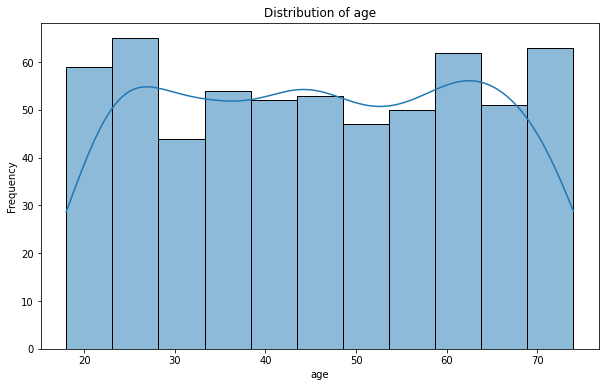

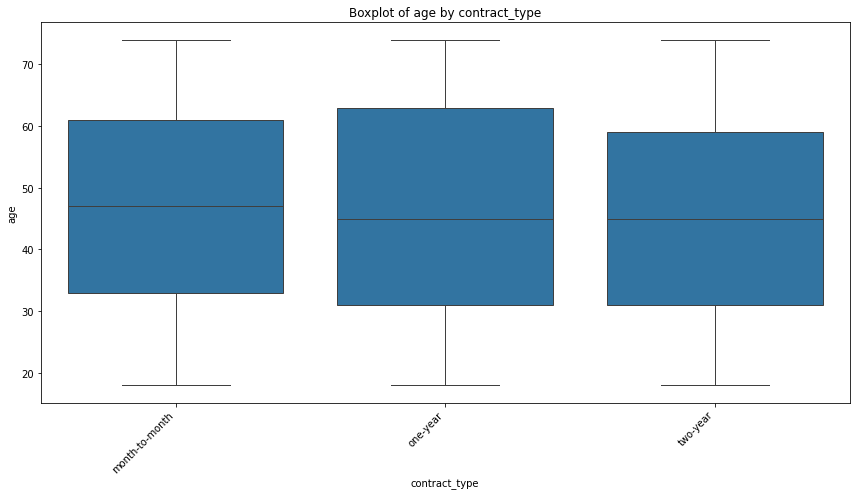

In [40]:
eda_prompt = (
    'Return ONLY Python code (no fences) defining a function `def analyze(df):`. '
    'Inside the function: '
    '1) Use pandas, seaborn, and matplotlib to perform a basic EDA. '
    '2) Print the results of df.describe(). '
    '3) Create two interesting plots (e.g., a histogram and a boxplot) to visualize the data. '
    '4) Do NOT call plt.show() or plt.close() inside the function. '
    '5) The function should not return any value. '
)

response = model_default.generate_content(eda_prompt, generation_config=GEN_CONFIG_EXTENDED)

# Check if the response was blocked before proceeding
if not response.candidates:
    print("Code generation failed. The response was blocked.")
    print("Reason:", response.prompt_feedback)
else:
    try:
        eda_code = response.text
        # Strip markdown fences if the model added them
        if eda_code.strip().startswith("```python"):
            eda_code = eda_code.strip().removeprefix("```python\n").removesuffix("\n```")
        # Add a print statement to debug the generated code
        print("--- Generated Code ---")
        print(eda_code)
        print("----------------------")

        # The sandbox provides the allowed modules.
        # We  allow standard functions.
        sandbox = {'pd': pd, 'np': np, 'sns': sns, 'plt': plt, 'stats': stats}
        exec(compile(eda_code, '<generated>', 'exec'), sandbox, sandbox)
        
        assert 'analyze' in sandbox, 'The generated code did not define the "analyze" function.'
        
        result = sandbox['analyze'](df)
        print("\n--- Analysis Results ---")
        print({k: ('ok' if not isinstance(v, (int, float, str)) else v) for k, v in result.items()})
        plt.show()
    except Exception as e:
        print(f"\nAn error occurred while executing the generated code: {e}")


### Exercice
Play with the above code generation model. How far can you push it?

### Exercice
Use the techniques of your choice to analyse the dataset `\data\weightHeightSex.txt`.  

In [53]:
import textwrap
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

# --- Étape 0 : chargement des données ---
file_path = r'weightHeightSex.txt'

df = pd.read_csv(
    file_path,
    sep=r'\s+',      # un ou plusieurs espaces
    quotechar='"',   # retire les guillemets
    engine='python'
)

# Normaliser les noms de colonnes : minuscules et strip
df.columns = df.columns.str.strip().str.lower()

# Convertir les colonnes numériques
df['height'] = pd.to_numeric(df['height'], errors='coerce')
df['weight'] = pd.to_numeric(df['weight'], errors='coerce')

# --- Étape 1 : créer le prompt-writer ---
task = textwrap.dedent('''
Write a Python function called `analyze(df)` that:
1) Performs a basic EDA on the dataframe `df`.
2) Prints df.describe().
3) Generates two plots: a histogram for Weight and a boxplot of Height by Sex.
4) Uses pandas, seaborn, matplotlib.
5) Does NOT call plt.show() or plt.close() inside the function.
6) Returns nothing.
''').strip()

prompt_writer = textwrap.dedent(f'''
You are a prompt engineer. Draft a clear, minimal prompt for another LLM to:
- Role: senior data scientist
- Task: {task}
- Output: Python code defining the function `analyze(df)` only, no extra text, no markdown fences
Return ONLY the prompt text that can be pasted into another model.
''').strip()

# --- Étape 2 : générer le prompt pour l'analyse ---
response = model_default.generate_content(prompt_writer, generation_config=GEN_CONFIG_EXTENDED)
analysis_prompt = response.text if response.text else "Error: No prompt generated"
print('--- Generated Prompt ---')
print(analysis_prompt)

# --- Étape 3 : générer le code de la fonction à partir du prompt ---
if analysis_prompt != "Error: No prompt generated":
    response = model_default.generate_content(analysis_prompt, generation_config=GEN_CONFIG_EXTENDED)
    eda_code = response.text if response.text else "Error: No code generated"

    # Strip markdown fences si le modèle en a ajouté
    if eda_code.strip().startswith("```python"):
        eda_code = eda_code.strip().removeprefix("```python\n").removesuffix("\n```")

    print('\n--- Generated Function Code ---')
    print(eda_code)

    # --- Étape 4 : exécuter la fonction générée ---
    sandbox = {'pd': pd, 'np': np, 'sns': sns, 'plt': plt}
    exec(compile(eda_code, '<generated>', 'exec'), sandbox, sandbox)

    assert 'analyze' in sandbox, 'The generated code did not define the analyze function.'

    # Appel de la fonction
    sandbox['analyze'](df)
    plt.show()


KeyError: 'height'